# Chapter 2 (Part 2):  Finetune your model



## Previously in Chapter 2:

### Import Libraries

In [ ]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

### Loading Data 

In [ ]:
#This is where the data are hosted
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" 
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" #data path

#This is where we will store downloaded data
HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

#Download data
fetch_housing_data()
#load the data
housing = load_housing_data()
print(housing.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


### Create a stratified train/test set

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
 strat_train_set = housing.loc[train_index]
 strat_test_set = housing.loc[test_index]

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Plot Train data

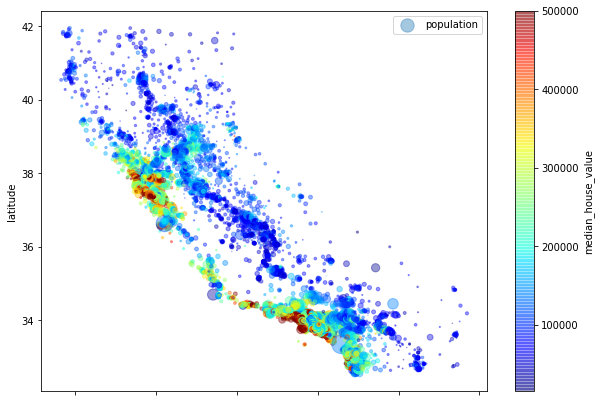

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)

plt.legend()

### Train data and labels

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data preparation

In [ ]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [ ]:
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler()),
 ])

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
housing_prepared = full_pipeline.fit_transform(housing)

### Train Linear Model

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

Train Decision Tree Model

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Train Random Forest Model

In [ ]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

### Use Cross Validation

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())


lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
 scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180644
Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928
Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


## Finetuning Hyper Parameters

Let’s assume that you now have a shortlist of promising models. You now need to
fine-tune them. Let’s look at a few ways you can do that.

One way to do that would be to fiddle with the hyperparameters manually, until you
find a great combination of hyperparameter values. This would be very tedious work,
and you may not have time to explore many combinations.

Instead you should get Scikit-Learn’s GridSearchCV to search for you. All you need to
do is tell it which hyperparameters you want it to experiment with, and what values to
try out, and it will evaluate all the possible combinations of hyperparameter values,
using cross-validation. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:


```
class  sklearn.ensemble.RandomForestRegressor(
  n_estimators=100, 
  criterion='squared_error',
  max_depth=None, 
  min_samples_split=2, 
  min_samples_leaf=1, 
  min_weight_fraction_leaf=0.0, 
  max_features='auto', 
  max_leaf_nodes=None, 
  min_impurity_decrease=0.0, 
  bootstrap=True, 
  oob_score=False, 
  n_jobs=None, 
  random_state=None, 
  verbose=0, 
  warm_start=False, 
  ccp_alpha=0.0, 
  max_samples=None
)
```

Try to finetune the following hyper parameters using GridSearchCV:
- With bootstrap: 
  - n_estimators : 3,5,10,30
  - max_features : 1,2,4,8

- Without bootstrap: 
  - n_estimators : 3,10
  - max_features : 2,3,4


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators':[3,5,10,30],'max_features': [1,2,4,8]},{'n_estimators': [3,10],'max_features': [2,3,4],'bootstrap':[False]}]
forest_reg = RandomForestRegressor()
grid_search =GridSearchCV(forest_reg,param_grid, cv=5) 

#Fit the grid search
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [1, 2, 4, 8],
                          'n_estimators': [3, 5, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}])

Get best parameters

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

or get the best estimator directly

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

Check the evaluation scores of the GridSearch

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

nan {'max_features': 1, 'n_estimators': 3}
nan {'max_features': 1, 'n_estimators': 5}
nan {'max_features': 1, 'n_estimators': 10}
nan {'max_features': 1, 'n_estimators': 30}
nan {'max_features': 2, 'n_estimators': 3}
nan {'max_features': 2, 'n_estimators': 5}
nan {'max_features': 2, 'n_estimators': 10}
nan {'max_features': 2, 'n_estimators': 30}
nan {'max_features': 4, 'n_estimators': 3}
nan {'max_features': 4, 'n_estimators': 5}
nan {'max_features': 4, 'n_estimators': 10}
nan {'max_features': 4, 'n_estimators': 30}
nan {'max_features': 8, 'n_estimators': 3}
nan {'max_features': 8, 'n_estimators': 5}
nan {'max_features': 8, 'n_estimators': 10}
nan {'max_features': 8, 'n_estimators': 30}
nan {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
nan {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
nan {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
nan {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
nan {'bootstrap': False, 'max_features': 4, 'n_est

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


The grid search approach is fine when you are exploring relatively few combinations,
like in the previous example, but when the hyperparameter search space is large, it is
often preferable to use RandomizedSearchCV instead. This class can be used in much
the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random
value for each hyperparameter at every iteration. This approach has two main benefits:
* If you let the randomized search run for, say, 1,000 iterations, this approach will
explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
* You have more control over the computing budget you want to allocate to hyper‐
parameter search, simply by setting the number of iterations.

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

#show feat importance and their corresponding columns (sorted)
sorted(zip(feature_importances,attributes),reverse=True)

[(0.3667275965558939, 'median_income'),
 (0.17520996293028462, 'INLAND'),
 (0.11210599513502172, 'pop_per_hhold'),
 (0.0709940103611302, 'longitude'),
 (0.061071255958426975, 'latitude'),
 (0.055945626931071954, 'rooms_per_hhold'),
 (0.04565901462618591, 'bedrooms_per_room'),
 (0.042928888220400994, 'housing_median_age'),
 (0.015215357919390585, 'total_rooms'),
 (0.014979569883769143, 'total_bedrooms'),
 (0.014920535521136227, 'households'),
 (0.014753102160555004, 'population'),
 (0.004285159096853691, '<1H OCEAN'),
 (0.0031460562271145077, 'NEAR OCEAN'),
 (0.001983527105981582, 'NEAR BAY'),
 (7.434136678304176e-05, 'ISLAND')]

## Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For
example, the RandomForestRegressor can indicate the relative importance of each
attribute for making accurate predictions:

Add new Transformer to select only best features

In [ ]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ =  indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return  X[:, self.feature_indices_]

Append the new transformer to data preparation

In [ ]:
preparation_and_feature_selection_pipeline = #create new pipeline !
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Train the model and use RandomizedSearchCV for hyperparameter tuning

In [ ]:
parameters = # define list of parameters for RandomizedSearchCV
forest_reg = RandomForestRegressor()
rand_search = # define RandomizedSearchCV for 10 iteration
rand_search.fit(housing_prepared_top_k_features, housing_labels)

## Evaluate Your System on the Test Set



After tweaking your models for a while, you eventually have a system that performs
sufficiently well. Now is the time to evaluate the final model on the test set. There is
nothing special about this process; just get the predictors and the labels from your
test set, run your full_pipeline to transform the data (call transform(), not
fit_transform(), you do not want to fit the test set!), and evaluate the final model
on the test set:

In [ ]:
final_model = grid_search.best_estimator_
#get the final rmse using test set !







In [ ]:
final_rmse